# The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (i.e., name, age, gender, socio-economic class, etc).

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, precision_recall_curve, matthews_corrcoef
import pickle
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from data_visualisation import Data_Visualisation as dv
from data_preparation import Data_Preparation as dp

In [3]:
df = pd.read_csv("Downloads/titanic.csv")
del df["Unnamed: 0"]

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [5]:
dp.summary(df)

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,PassengerId,0,0.0,int64,1309
1,Survived,0,0.0,int64,2
2,Pclass,0,0.0,int64,3
3,Name,0,0.0,object,1307
4,Sex,0,0.0,object,2
5,Age,263,20.0,float64,99
6,SibSp,0,0.0,int64,7
7,Parch,0,0.0,int64,8
8,Ticket,0,0.0,object,929
9,Fare,1,0.0,float64,282


* Cabin has 77% missing values, we can drop this column.
* Name isn't relevant for exploration or model training so we will drop it.
* Age has 20% missing values, we will fill it with average.
* Let's fill Embark with the mode value which is 'S'.
* Since there is one missing value we don't know on 'Fare' we will drop the row.

In [6]:
del df["Cabin"]
#we don't need name
del df['Name']

In [7]:
df["Age"] = df["Age"].fillna(df["Age"].mean())
#it's two missing value for embarked, so let's fill it with one of it's values
df["Embarked"] = df["Embarked"].fillna('S')
df = df.dropna()

In [8]:
dp.summary(df)

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,PassengerId,0,0.0,int64,1308
1,Survived,0,0.0,int64,2
2,Pclass,0,0.0,int64,3
3,Sex,0,0.0,object,2
4,Age,0,0.0,float64,98
5,SibSp,0,0.0,int64,7
6,Parch,0,0.0,int64,8
7,Ticket,0,0.0,object,928
8,Fare,0,0.0,float64,281
9,Embarked,0,0.0,object,3


In [9]:
pd.value_counts(df["Survived"])

0    814
1    494
Name: Survived, dtype: int64

In [10]:
lis1=["Survived", "Died"]
lis2=[494, 815]

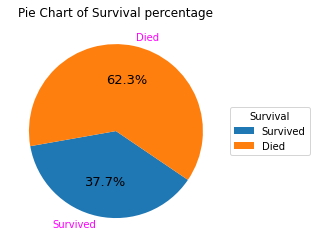

0    814
1    494
Name: Survived, dtype: int64

In [11]:
dv.plot_pie(lis1, lis2, df["Survived"], "Survival", "Pie Chart of Survival percentage")

* People that survived the titanic are below 500, which makes up approximately 38%

* Let's see how many male and female survived

In [12]:
#extract the dataset with survived people
df2 = df[df.Survived != 0]
#extract male
male = df2[df2.Sex == "male"]
#extract female
female = df2[df2.Sex == "female"]
print(male.shape)
print(female.shape)

(109, 10)
(385, 10)


* 109 male survived and 385 female survived.

3    708
1    323
2    277
Name: Pclass, dtype: int64

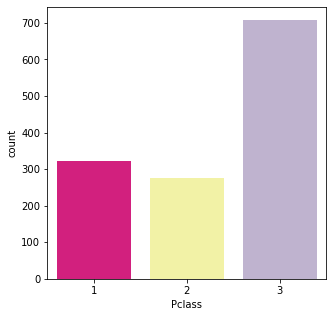

In [13]:
dv.plot_bargraph(df, "Pclass")

* The majority are third class passangers while the minority are second class

male      842
female    466
Name: Sex, dtype: int64

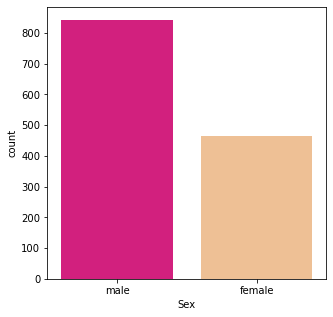

In [14]:
dv.plot_bargraph(df, "Sex")

0    890
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

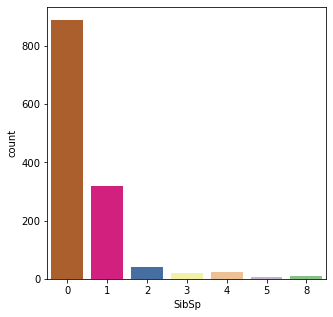

In [15]:
dv.plot_bargraph(df, "SibSp")

* Most of the passangers don't have a spouse or siblings
* 418 passangers are present with one or more spouse or siblings

S    915
C    270
Q    123
Name: Embarked, dtype: int64

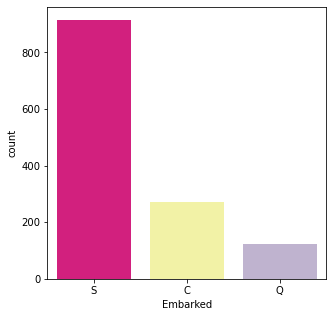

In [16]:
dv.plot_bargraph(df, "Embarked")

* The destination of most passangers were Southampton followed by Cherbourg, with some more than hundered headed to Queenstown

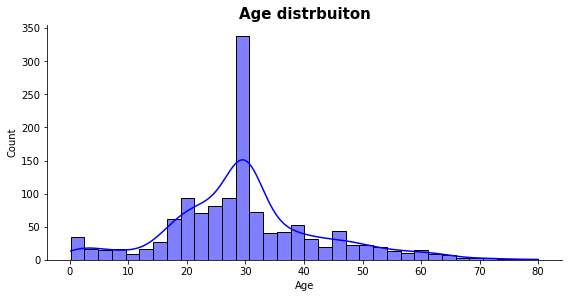

In [17]:
dv.show_distribution(df, "Age", "blue", "Age distrbuiton")

* Majority of the passangers were youths in their 20's and 30's

0    1001
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: Parch, dtype: int64

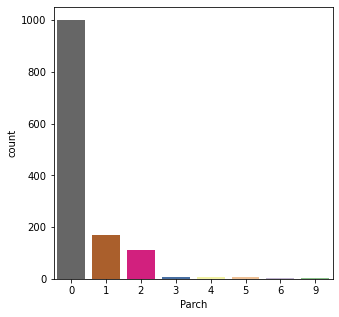

In [18]:
dv.plot_bargraph(df, "Parch")

* 307 people were abroad either with their parents or with their childrens

## Model Selection

Our target variable is "Survived", with a descrete value of 0 or 1 which means we have to choose a classification model.
In Classification model there are:-
* Logstic Regression
* Descision Tree
* XGBoost
* SVM
* Random Forest
* Gradient-boosted tree
* Multilayer perceptron
* One-vs-rest
* Naive Bayes

From the start we can rule out **One-vs-rest** classification because it is a heuristic method for using binary classification algorithms for multi-class classification, but our classification is binary (survived/not survived) already.

Let's plot a pairplot to furtherly narrow down our selection.

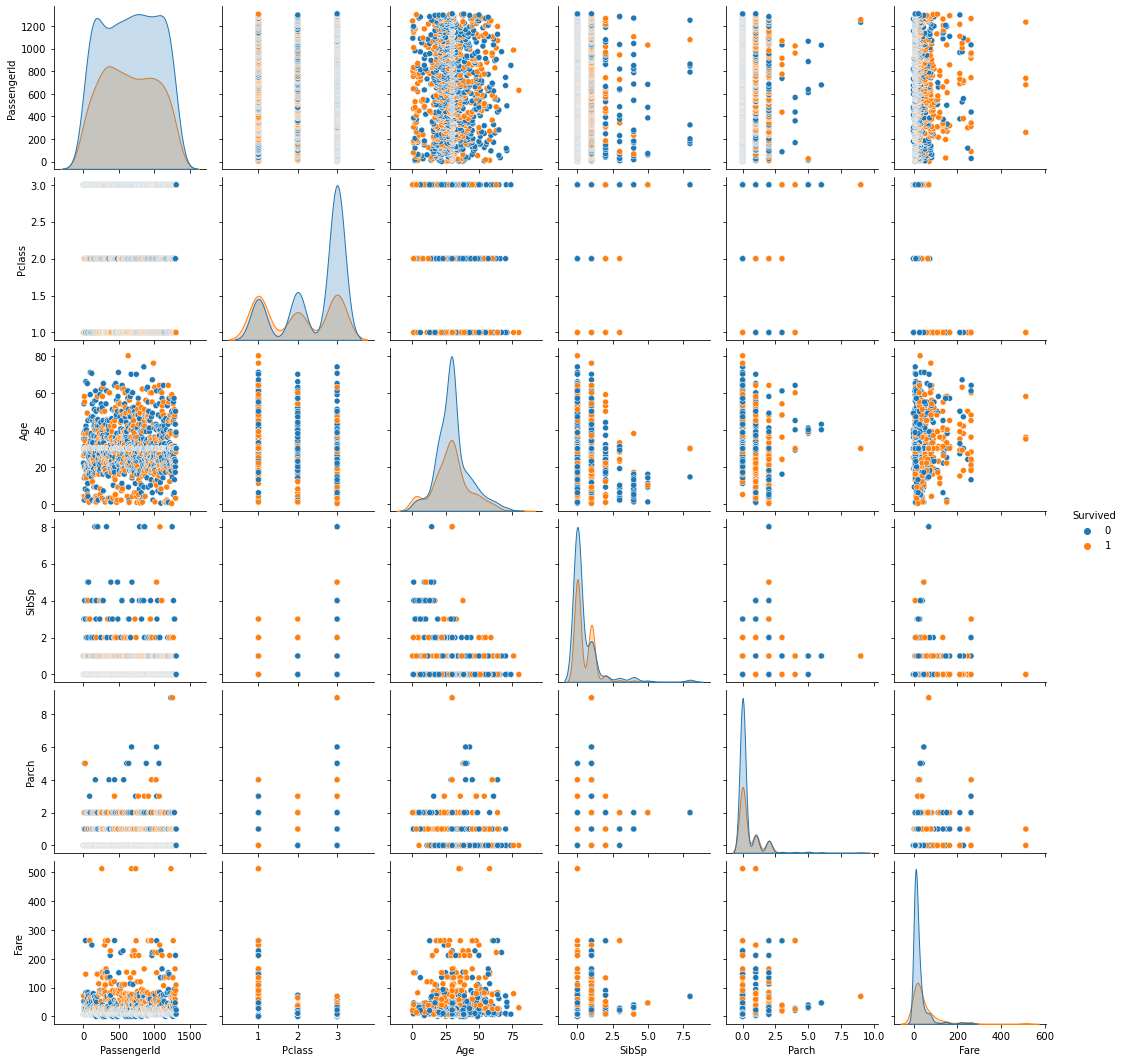

In [19]:
sns.pairplot(df, hue='Survived')

As we can see from the pairplot, there is quite visible overlap between features which can only means that the classifications are non-linear, so we will rule out **Logisitic Regression Model**, **Multilayer Perception** and **Support Vector Machine (SVM)** which are linear classifiers.

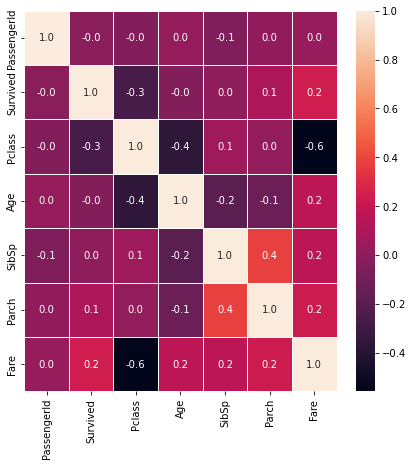

In [20]:
dv.plot_heatmap(df)

We can rule out **Naive Beyes classification**, because it limits the applicability of this algorithm in real-world use cases. So as titatnic being real-world uses case, we will let this one go.

When comparing Descision Tree with Random Forest, Random Forest can give us accurate prediction because The rationale is that although a single tree may be inaccurate, the collective decisions of a bunch of trees are likely to be right most of the time. So for the sake of accuracy let's rule out **Descision Tree**.

When comparing Gradient Boosting Trees with Random Forest, Gradient Boosting Trees can be more accurate than Random Forests. Because we train them to correct each other’s errors, they’re capable of capturing complex patterns in the data. However, if the data are noisy, the boosted trees may overfit and start modeling the noise. So we can rule out **Gradient Boosting**. Also **XGBoost** is one form of Gradient Boosting so we can rule that out too.

### Choice: Random Forest Regression

## Preprocessing

Because I have Chosen Random Forest Classfier which is scale-invariant I don't need feature scaling techniques. Ensemble methods do not require feature scaling to be performed as they are not sensitive to the the variance in the data.

But we have to encode it, so should we choose **label encoding** or **one-hot encoding**?
The answer is label encoding, why?

Random Forest Classfier works by ensembeling: combinining prediction of different decsion trees and voting, so by one-hot encoding a categorical variable, we are inducing sparsity into the dataset which is undesirable.

From the splitting algorithm’s point of view, all the dummy variables are independent. If the tree decides to make a split on one of the dummy variables, the gain in purity per split is very marginal. As a result, the tree is very unlikely to select one of the dummy variables closer to the root.

This two reasons will affect the accuracy of the prediciton. So it's better to choose label encoding which doesn't affect the dimensionality of the dataset and give us a better accuracy. For more information: https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1308 non-null   int64  
 1   Survived     1308 non-null   int64  
 2   Pclass       1308 non-null   int64  
 3   Sex          1308 non-null   object 
 4   Age          1308 non-null   float64
 5   SibSp        1308 non-null   int64  
 6   Parch        1308 non-null   int64  
 7   Ticket       1308 non-null   object 
 8   Fare         1308 non-null   float64
 9   Embarked     1308 non-null   object 
dtypes: float64(2), int64(5), object(3)
memory usage: 144.7+ KB


In [22]:
cat = ['Ticket', 'Sex', 'Embarked']

In [23]:
# Import label encoder

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
for i in cat:
    df[i]= label_encoder.fit_transform(df[i])
df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,1,22.000000,1,0,719,7.2500,2
1,2,1,1,0,38.000000,1,0,815,71.2833,0
2,3,1,3,0,26.000000,0,0,913,7.9250,2
3,4,1,1,0,35.000000,1,0,65,53.1000,2
4,5,0,3,1,35.000000,0,0,648,8.0500,2
...,...,...,...,...,...,...,...,...,...,...
1304,1305,0,3,1,29.881138,0,0,710,8.0500,2
1305,1306,1,1,0,39.000000,0,0,833,108.9000,0
1306,1307,0,3,1,38.500000,0,0,871,7.2500,2
1307,1308,0,3,1,29.881138,0,0,579,8.0500,2


In [24]:
lis  = []
for x in df.columns.to_list():
    if(x!='Survived' and x!='Ticket' and x!='PassengerId'):
        lis.append(x)
        
x= df[lis]
y=df['Survived']

In [25]:
x.to_csv("titanic_to_predict.csv")

In [26]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0) # 70% training and 30% test

In [27]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

#### Model Performance

The following are metrics to measure classification performance
* Accuracy
* Confusion metrix
* AUC/ROC
* Precision
* Recall
* F1 Score
* Kappa
* MCC

In [28]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8396946564885496


* The Accuracy of the model is 84%.

In [29]:
# save the model
filename = "Models/survival_classifier.pkl"
pickle.dump(clf, open(filename, 'wb'))

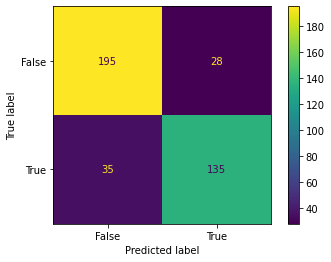

In [30]:
#Confusion Metrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()

Confusion Matrix have four quadrants
* True Negative (Top-Left Quadrant)
* False Positive (Top-Right Quadrant)
* False Negative (Bottom-Left Quadrant)
* True Positive (Bottom-Right Quadrant)

True means the values were actually predicted. False means there was an error or false prediction.

We can also say, False Positive, predicts an event when there was no event.

False Negative predicts no event when in fact there was an event.

**AUC/ROC**

A useful tool when predicting the probability of a binary outcome is the **Receiver Operating Characteristic curve**, or ROC curve.

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

The roc_curve() function returns the false positive rates for each threshold, true positive rates for each threshold and thresholds.

In [44]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

Like the roc_curve(), the auc function takes the true outcomes and the predicted probablities.

It returns the auc score between 0.0 to 1.0 (no skill to diagnose false alarm/hit rate to outstanding skill) 

In [31]:
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 0.834


AUC score of 0.8 to 0.9 is considered excellent, it means it was able to distnguish the false alarm and the hit rate.

* AUC/ROC

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.919


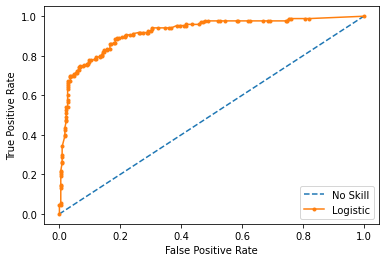

In [38]:
lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

**Precision**

It answers the question of the positives predicted, what percentage is truly positive?

Precision does not evaluate the correctly predicted negative cases.

In [47]:
Precision = metrics.precision_score(y_test, y_pred)
Precision

0.8282208588957055

* 82% is truly positive in our case.

**Recall**

Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. 

Recall is also known as sensitivity.

In [53]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

**F1 Score**

F1 Score is one of a composite score that summarizes precision and recall.

It calculates the harmonic mean of precision and recall; it's harmonic because precision and recall are rates.

the f1_score() takes the true class values and the prediction class values

In [59]:
# calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.8108108108108107


* ROC curve vs Precision-recall curves

***ROC curves should be used when there are roughly equal numbers of observations for each class.***

***Precision-Recall curves should be used when there is a moderate to large class imbalance.***

I think in our case Precision-Recall curve is the better choice.

**Kappa**

Kappa Score is a statistical measure of inter-rater agreement for categorical data.

It is generally used in situations where there are two raters, but it can also be adapted for use with more than two raters.

For machine learning binary classification models, one of the raters become the classification model and the other rater becomes the real-world observer who knows the actual truth about the categories of each of the record or dataset. 

In [61]:
cohen_kappa_score(y_test, y_pred)

0.6718445572505931

With 1 being perfect agreement and 0 being no agreement between the raters, our kappa score is 0.67.

**MCC**

MCC can be a better option for us, because is imbalance between classes.

MCC ranges from -1 to 1:-
    -1: total disagreement between predicted classes and actual classes
    0: random guessing between predicted classes and actual classes
    1: total agreement between predicted classes and actual classes

In [64]:
#calculate Matthews correlation coefficient
matthews_corrcoef(y_test, y_pred)

0.6722915971720831

* It's approximately similar with our kappa score.